## Author : Prateek
## Visualize contact related data

In [1]:
import pickle
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
%matplotlib inline

# covid19sim
from covid19sim.log.track import LOCATION_TYPES_TO_TRACK_MIXING
from covid19sim.utils.constants import AGE_BIN_WIDTH_5

# labels
ticks = [x[0] for x in AGE_BIN_WIDTH_5]
str_ticks = [f"{x[0]} - {x[1]}" for x in AGE_BIN_WIDTH_5]
n_ticks = len(ticks)

In [39]:
def get_population_contact_matrix(data, location, interaction):
    social_contact_matrix = data['contact_patterns']['contact_matrices'][interaction][location]['unique_avg_daily'][1]

    # divide the unique contacts with population in each age group 
    # i,j = unique contacts per person reported j about i
    social_contact_matrix, n_people = compute_density_of_contacts(social_contact_matrix, data)

    # adjust for reciprocity
    population_contact_matrix = np.zeros_like(social_contact_matrix)
    for j in range(len(AGE_BIN_WIDTH_5)):
        for i in range(len(AGE_BIN_WIDTH_5)):
            w_i = n_people[i]
            w_j = n_people[j]
            population_contact_matrix[i,j] = 0.5 * (social_contact_matrix[i,j] + social_contact_matrix[j,i] * w_i / w_j ) 
    
    return population_contact_matrix

In [42]:
def compute_density_of_contacts(matrix, data):
    N_PEOPLE = sorted(data['age_histogram'].items(), key=lambda x:x[0])
    # divide the unique contacts with population in each age group 
    # i,j = unique contacts per person reported j about i
    n_people = np.array([x[1] for x in N_PEOPLE])
    return matrix / n_people, n_people

def get_matrix(matrix_name, metric=None):
    if matrix_name == "social_contact_matrix" or metric == "unique_avg_daily":
        return get_population_contact_matrix
        
    def _get_matrix(data, location, interaction):
        matrix = data['contact_patterns'][matrix_name][interaction][location][metric][1]
        if metric == "avg_daily":
            matrix, _ = compute_density_of_contacts(matrix, data)
        return matrix
    return _get_matrix

In [4]:
# labels
INTERACTION_TYPES = ["known", "all", "within_contact_condition"]
INTERACTION_TYPE_LABELS = {
    "known": "Known Contacts",
    "within_contact_condition": "All \n($d < 2m$ and $t > 15min$)",
    "all": "All contacts"
}

LOCATION_LABELS = {
    "house": "House",
    "work": "Work",
    "other": "Other",
    "school": "School",
    "all": "All"
}



In [5]:
def plot_matrices(data, get_matrix, TITLE):
    TITLESIZE = 40
    TITLEPAD = 40
    YLABELSIZE = 40
    YLABELPAD = 100
    TICKSIZE = 25

    HEIGHT = 7
    WIDTH = 7.5
    EXTRA_WIDTH = 3

    ncols = 3 # ['known', 'all', 'within_contact_condition']
    if len(data['contact_patterns']['bluetooth_contact_matrices'].keys()) > 0:
        ncols += 1 # plot bluetooth communication
        # add type

    nrows = len(LOCATION_TYPES_TO_TRACK_MIXING)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(WIDTH*ncols+EXTRA_WIDTH, HEIGHT*nrows), sharex=True, sharey=True)

    # set row and column headers 
    for col in range(ncols):
        interaction = INTERACTION_TYPE_LABELS[INTERACTION_TYPES[col]]
        axs[0, col].set_title(interaction, pad=TITLEPAD, fontsize=TITLESIZE)

    for row in range(nrows):
        location = LOCATION_LABELS[LOCATION_TYPES_TO_TRACK_MIXING[row]]
        axs[row, 0].set_ylabel(location, rotation=0, labelpad=YLABELPAD, fontsize=YLABELSIZE)

    for row in range(nrows):
        location = LOCATION_TYPES_TO_TRACK_MIXING[row]
        for col in range(ncols):
            interaction = INTERACTION_TYPES[col]
            ax = axs[row][col]

            # data
            # others
            matrix = get_matrix(data, location, interaction)
            im = ax.pcolor(matrix, cmap='viridis', linewidths=0.001, edgecolor="w")

            # set positioning 
            ax.set(adjustable='box', aspect=1)

            # xticks and labels
            ax.set_yticks(np.arange(n_ticks))
            ax.set_xticks(np.arange(n_ticks))
            ax.set_yticklabels(ticks, )
            ax.set_xticklabels(ticks, rotation=90) 

            # tick size
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(TICKSIZE)

            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(TICKSIZE)

        # colorbar for each row
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="10%", pad=0.50)
        cbar = fig.colorbar(im, ax=axs[row, :], cax=cax)
        cbar.ax.tick_params(labelsize=TICKSIZE) 

    fig.suptitle(TITLE, fontsize=50, y=1.05)
    return fig

In [59]:
filename = "../src/covid19sim/output/sim_v2_people-1000_days-15_init-0.001_uptake--1.0_seed-0_20200714-090209_106000/tracker_data_n_1000_seed_0_20200714-090400.pkl"
data = pickle.load(open(filename, "rb"))

In [ ]:
# following things can be plotted 

# matrices 
# contact_matrices
# duration_contact_matrices
# bluetooth_contact_matrices

# series 
# mean_daily_contacts_per_agegroup
# mean_daily_contact_duration_per_agegroup

# scalars 
# mean_daily_contacts
# mean_daily_contact_duration

# interaction characteristics
# contact_distance_profile
# contact_duration_profile

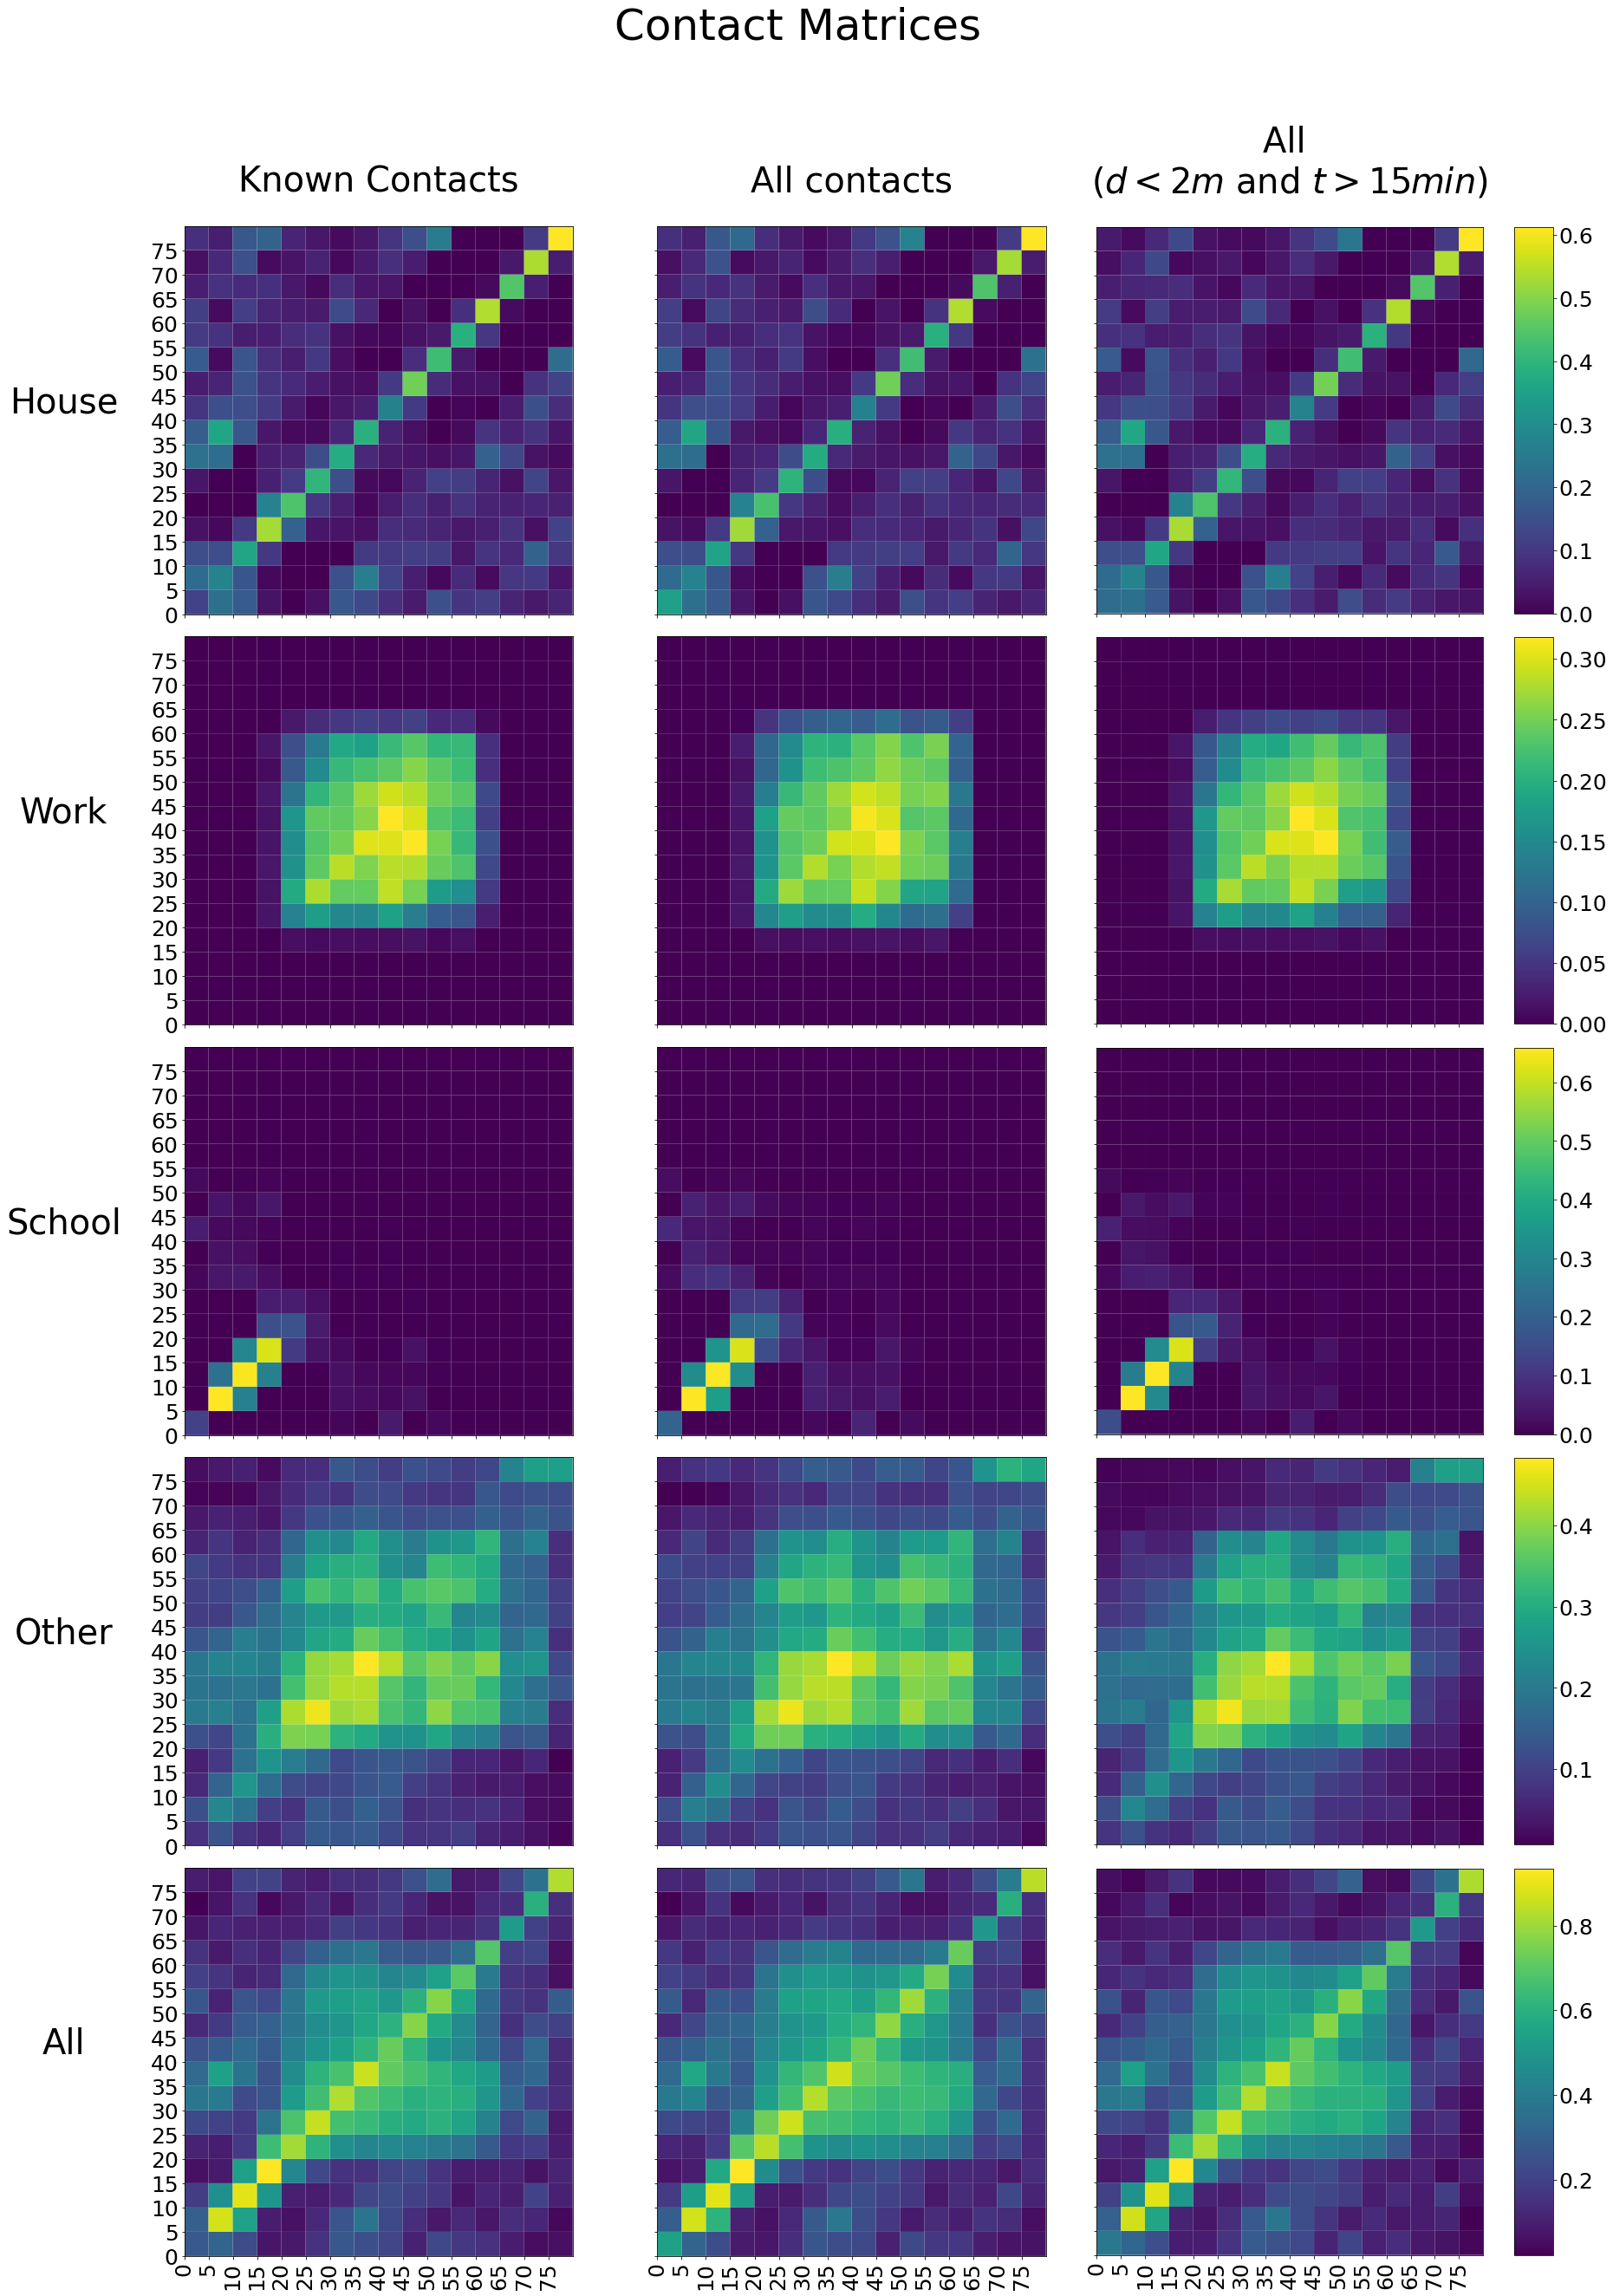

In [55]:
# MATRICES
# standardiazation is a method for standardizing a metric as per some feature of the population
# for example, we keep mean daily contacts between two age groups in "avg_daily". We standardize them by dividing the numbers in columns by total number of 
# people in that age bin. This is standarding "Avg" to demographics. 

## contact_matrices
# "avg_daily" ij - mean number of contacts per day standardized to the demographical age structure
# "avg" ij - mean number of contacts per day per person. Note: the difference is with respect to per person. 
# It differs from avg_daily if there is a big difference of contacts across the population in the same age groups.
# unique_avg_daily - ij - mean number of unique contacts standardized to the demographical age structure

## duration_contact_matrices
# "avg_daily" ij - mean number of contacts per day standardized to the demographical age structure
# "avg" ij - mean number of contacts per day per person. Note: the difference is with respect to per person. 

## bluetooth_contact_matrices
# "avg_daily" ij - mean number of contacts per day standardized to the demographical age structure

fig = plot_matrices(data, get_matrix('contact_matrices', "unique_avg_daily"), "Contact Matrices")
fig.tight_layout()
plt.show()
# fig.savefig("contact_duration", dpi=300, bbox_inches='tight')

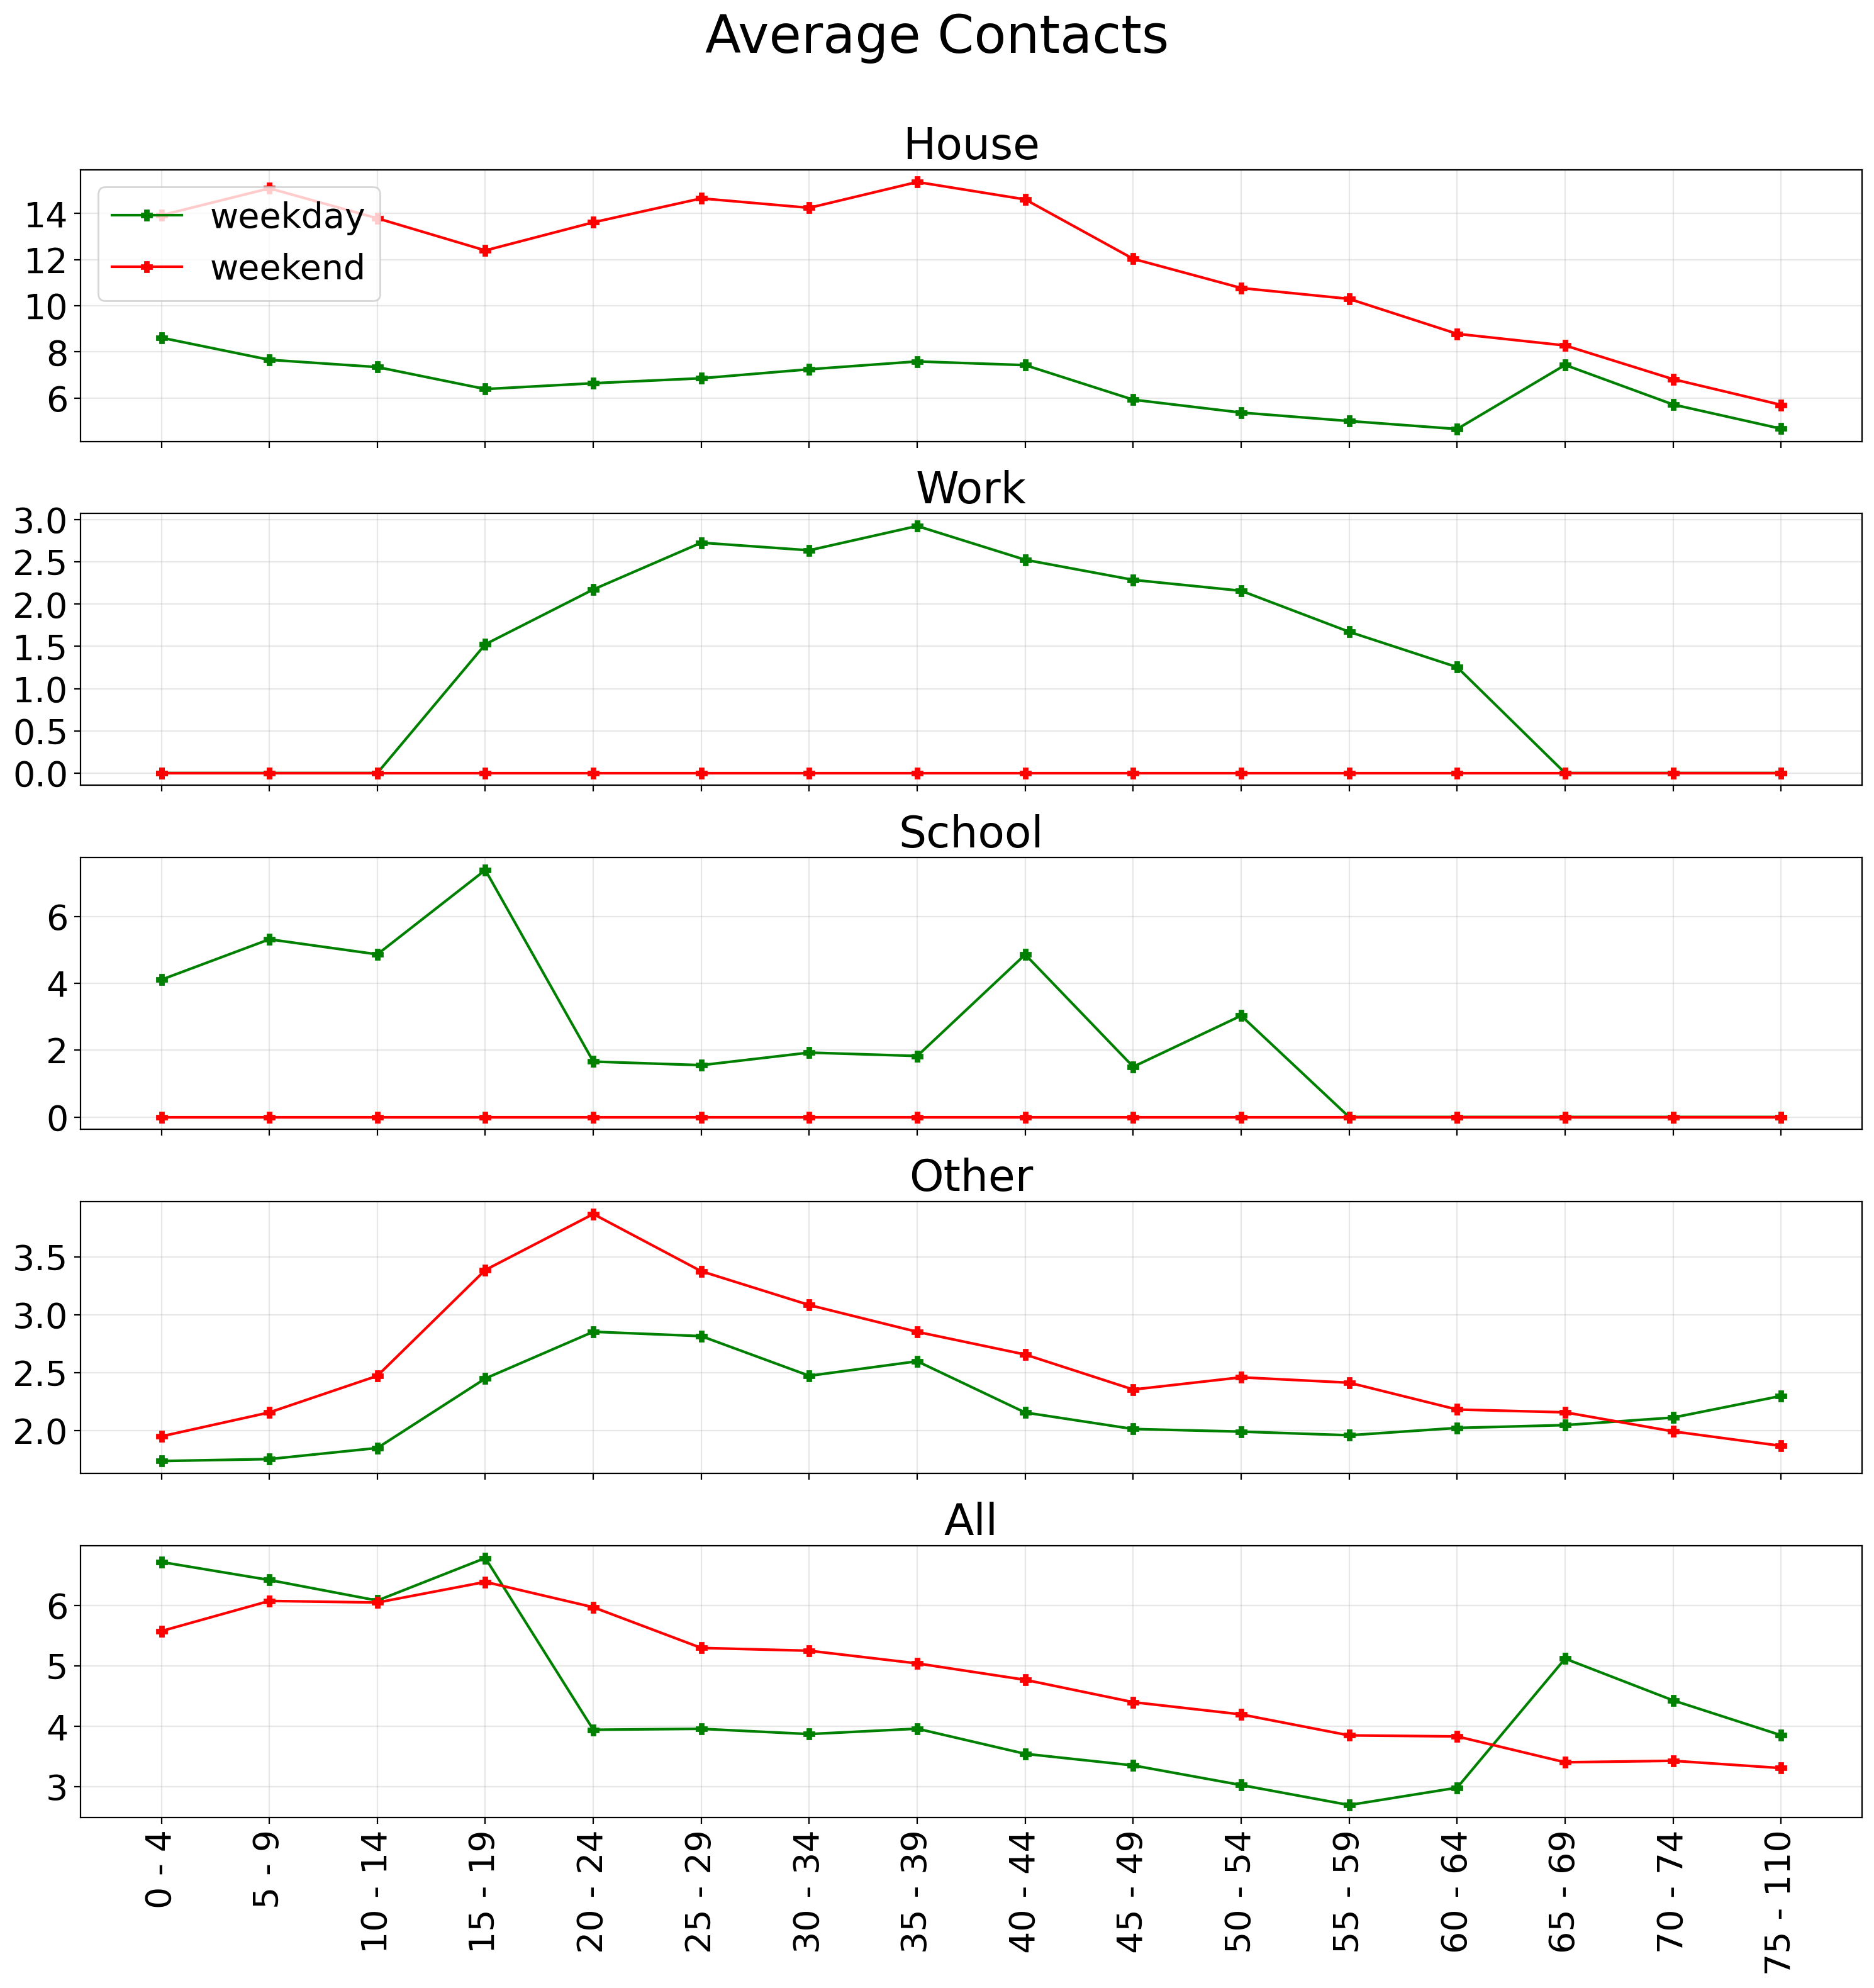

In [56]:
# series
# mean_daily_contacts_per_agegroup
# mean_daily_contact_duration_per_agegroup
series_name = "mean_daily_contacts_per_agegroup"
TITLE = "Average Contacts" if series_name == "mean_daily_contacts_per_agegroup" else "Average contact duration"

DAY_TYPES = ['weekday', 'weekend']
TICKSIZE = 20
TITLESIZE = 25
WEEKDAY_COLOR = "green"
WEEKEND_COLOR = "red"

nrows = len(LOCATION_TYPES_TO_TRACK_MIXING)
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(15,15), dpi=200, sharex=True)

for i in range(nrows):
    ax = axs[i]
    location_type = LOCATION_TYPES_TO_TRACK_MIXING[i]

    wkday_series = data['contact_patterns'][series_name]["weekday"][location_type][1]
    ax.plot(wkday_series, marker="P", color=WEEKDAY_COLOR, label="weekday")
    
    wkend_series = data['contact_patterns'][series_name]["weekend"][location_type][1]
    ax.plot(wkend_series, marker="P", color=WEEKEND_COLOR, label="weekend")

    # xticks and labels
    ax.set_xticks(np.arange(n_ticks))
    ax.set_xticklabels(str_ticks, rotation=90) 
    ax.set_title(LOCATION_LABELS[location_type], fontsize=TITLESIZE)
    
    # grid
    ax.grid(True, axis='x', alpha=0.3)
    ax.grid(True, axis='y', alpha=0.3)

    # tick size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)
    
    if i == 0:
        ax.legend(prop={"size":20}, loc="upper left")
    
fig.suptitle(TITLE, fontsize=30, y=1.05)
fig.tight_layout()
plt.show()
fig.savefig(series_name, dpi=300, bbox_inches='tight')

In [10]:
region_yaml = "../src/covid19sim/configs/simulation/region/montreal.yaml"
region_path = Path(region_yaml)
with region_path.open('r') as f:
    region = yaml.safe_load(f)

c_house_matrix = region['ADJUSTED_CONTACT_MATRIX_HOUSEHOLD']
c_work_matrix = region['ADJUSTED_CONTACT_MATRIX_WORK']
c_school_matrix = region['ADJUSTED_CONTACT_MATRIX_SCHOOL']
c_other_matrix = region['ADJUSTED_CONTACT_MATRIX_OTHER']
c_all_matrix = region['ADJUSTED_CONTACT_MATRIX_ALL']


p_house_matrix = region['P_CONTACT_MATRIX_HOUSEHOLD']
p_work_matrix = region['P_CONTACT_MATRIX_WORK']
p_school_matrix = region['P_CONTACT_MATRIX_SCHOOL']
p_other_matrix = region['P_CONTACT_MATRIX_OTHER']
p_all_matrix = region['P_CONTACT_MATRIX_ALL']

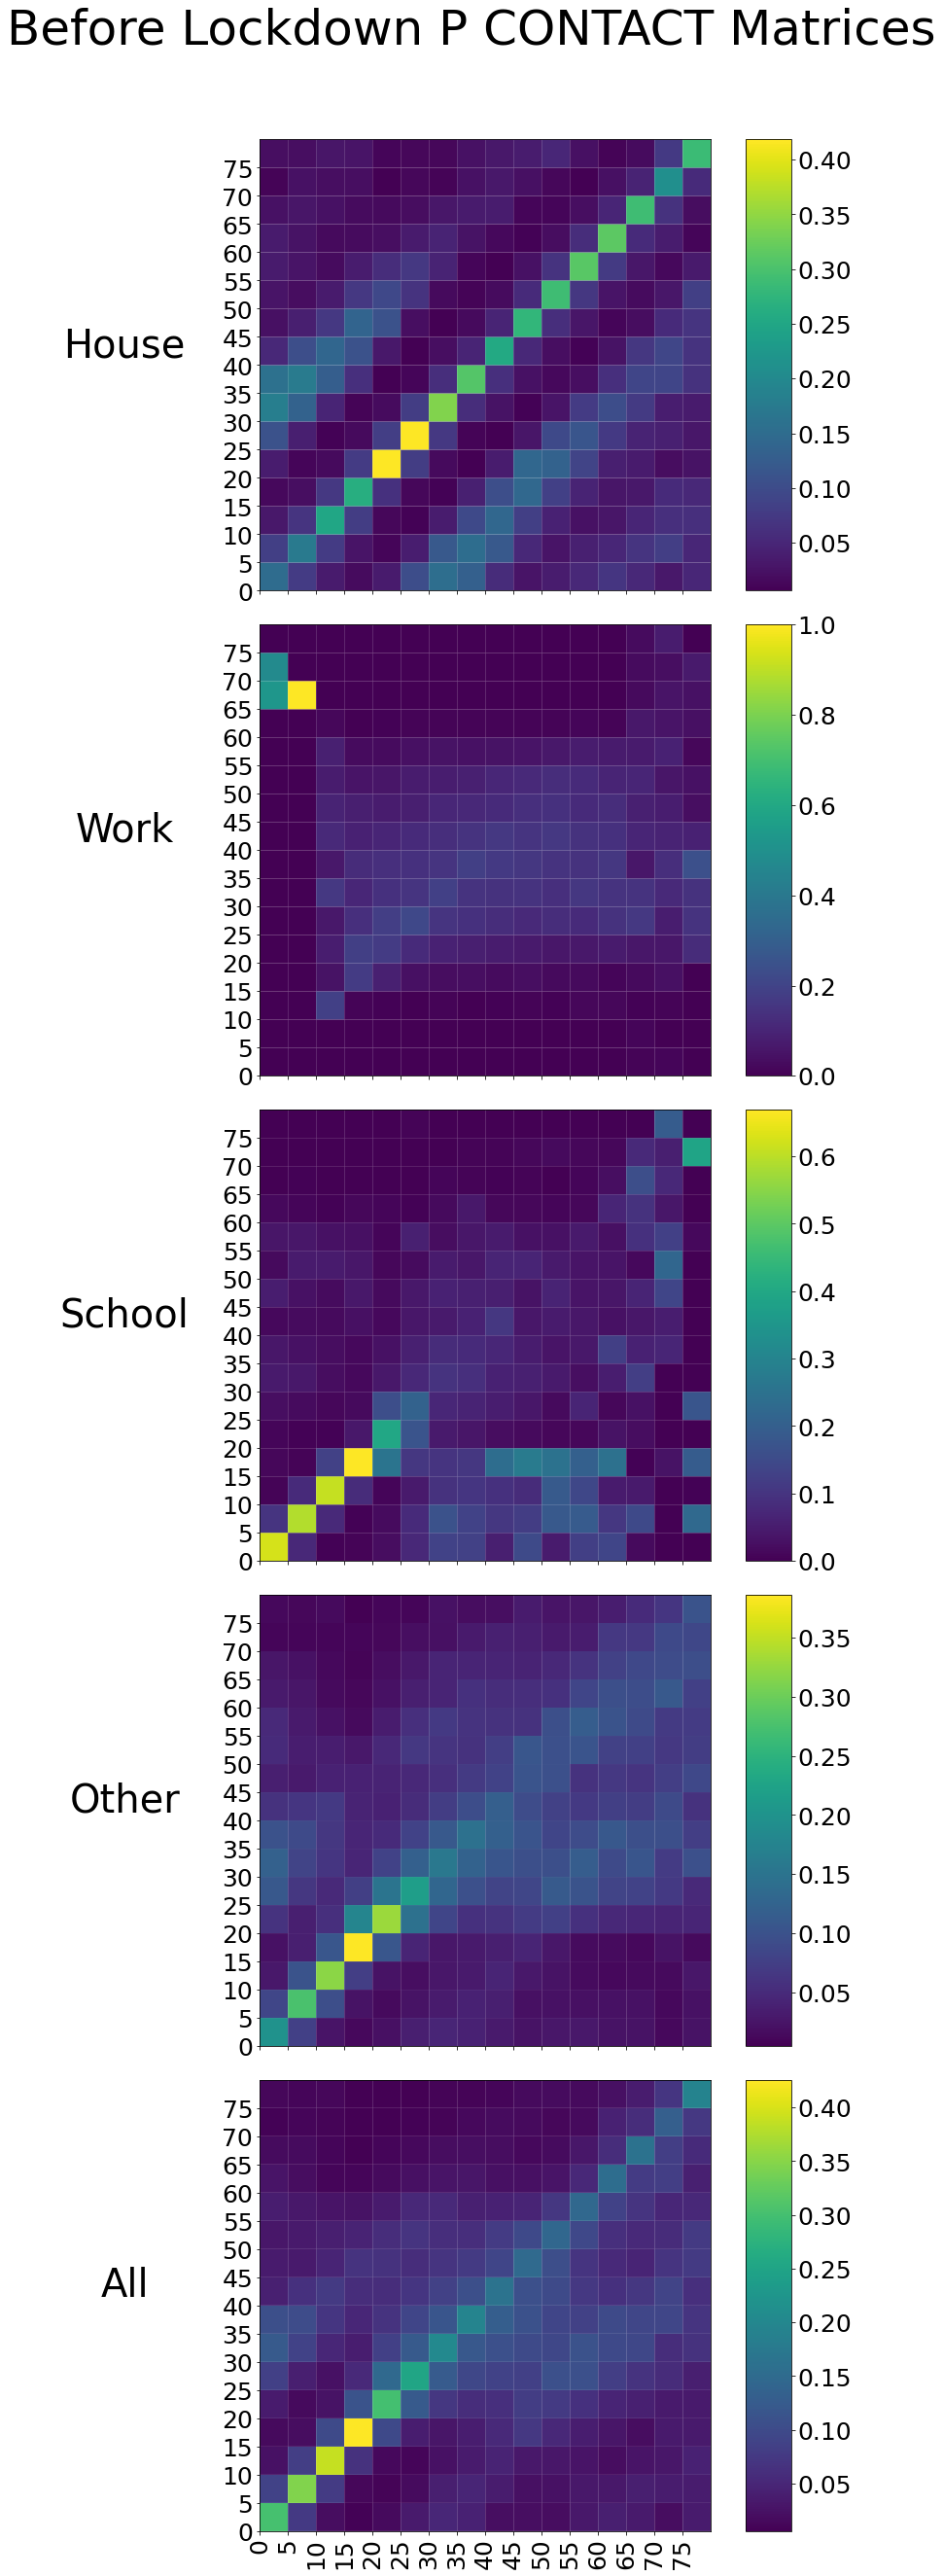

In [11]:
_type = "contact" # "probability" or "contact"
if _type == "probability":
    TITLE = "Before Lockdown P CONTACT Matrices"
    matrices = [p_house_matrix, p_work_matrix, p_school_matrix, p_other_matrix, p_all_matrix]
elif _type == "contact":
    TITLE = "Before Lockdown CONTACT Matrices"
    matrices = [c_house_matrix, c_work_matrix, c_school_matrix, c_other_matrix, c_all_matrix]
else:
    raise ValueError
    
labels = ["House", "Work", "School", "Other", "All"]

TITLESIZE = 40
TITLEPAD = 40
YLABELSIZE = 40
YLABELPAD = 100
TICKSIZE = 25

HEIGHT = 7
WIDTH = 7.5
EXTRA_WIDTH = 3

ncols = 1 # ['known', 'all', 'within_contact_condition']
nrows = 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(WIDTH*ncols+EXTRA_WIDTH, HEIGHT*nrows), sharex=True)

# set row and column headers 
for row, label in enumerate(labels):
    ax = axs[row]
    
    ax.set_ylabel(label, rotation=0, labelpad=YLABELPAD, fontsize=YLABELSIZE)
        
    matrix = matrices[row]
    im = ax.pcolor(matrix, cmap='viridis', linewidths=0.001, edgecolor="w")

    # set positioning 
    ax.set(adjustable='box', aspect=1)

    # xticks and labels
    ax.set_yticks(np.arange(n_ticks))
    ax.set_xticks(np.arange(n_ticks))
    ax.set_yticklabels(ticks)
    ax.set_xticklabels(ticks, rotation=90) 

    # tick size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)
    
    # colorbar for each row
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.50)
    cbar = fig.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=TICKSIZE) 

fig.suptitle(TITLE, fontsize=50, y=1.05)
fig.tight_layout()
plt.show()
fig.savefig("reference", dpi=300, bbox_inches='tight')

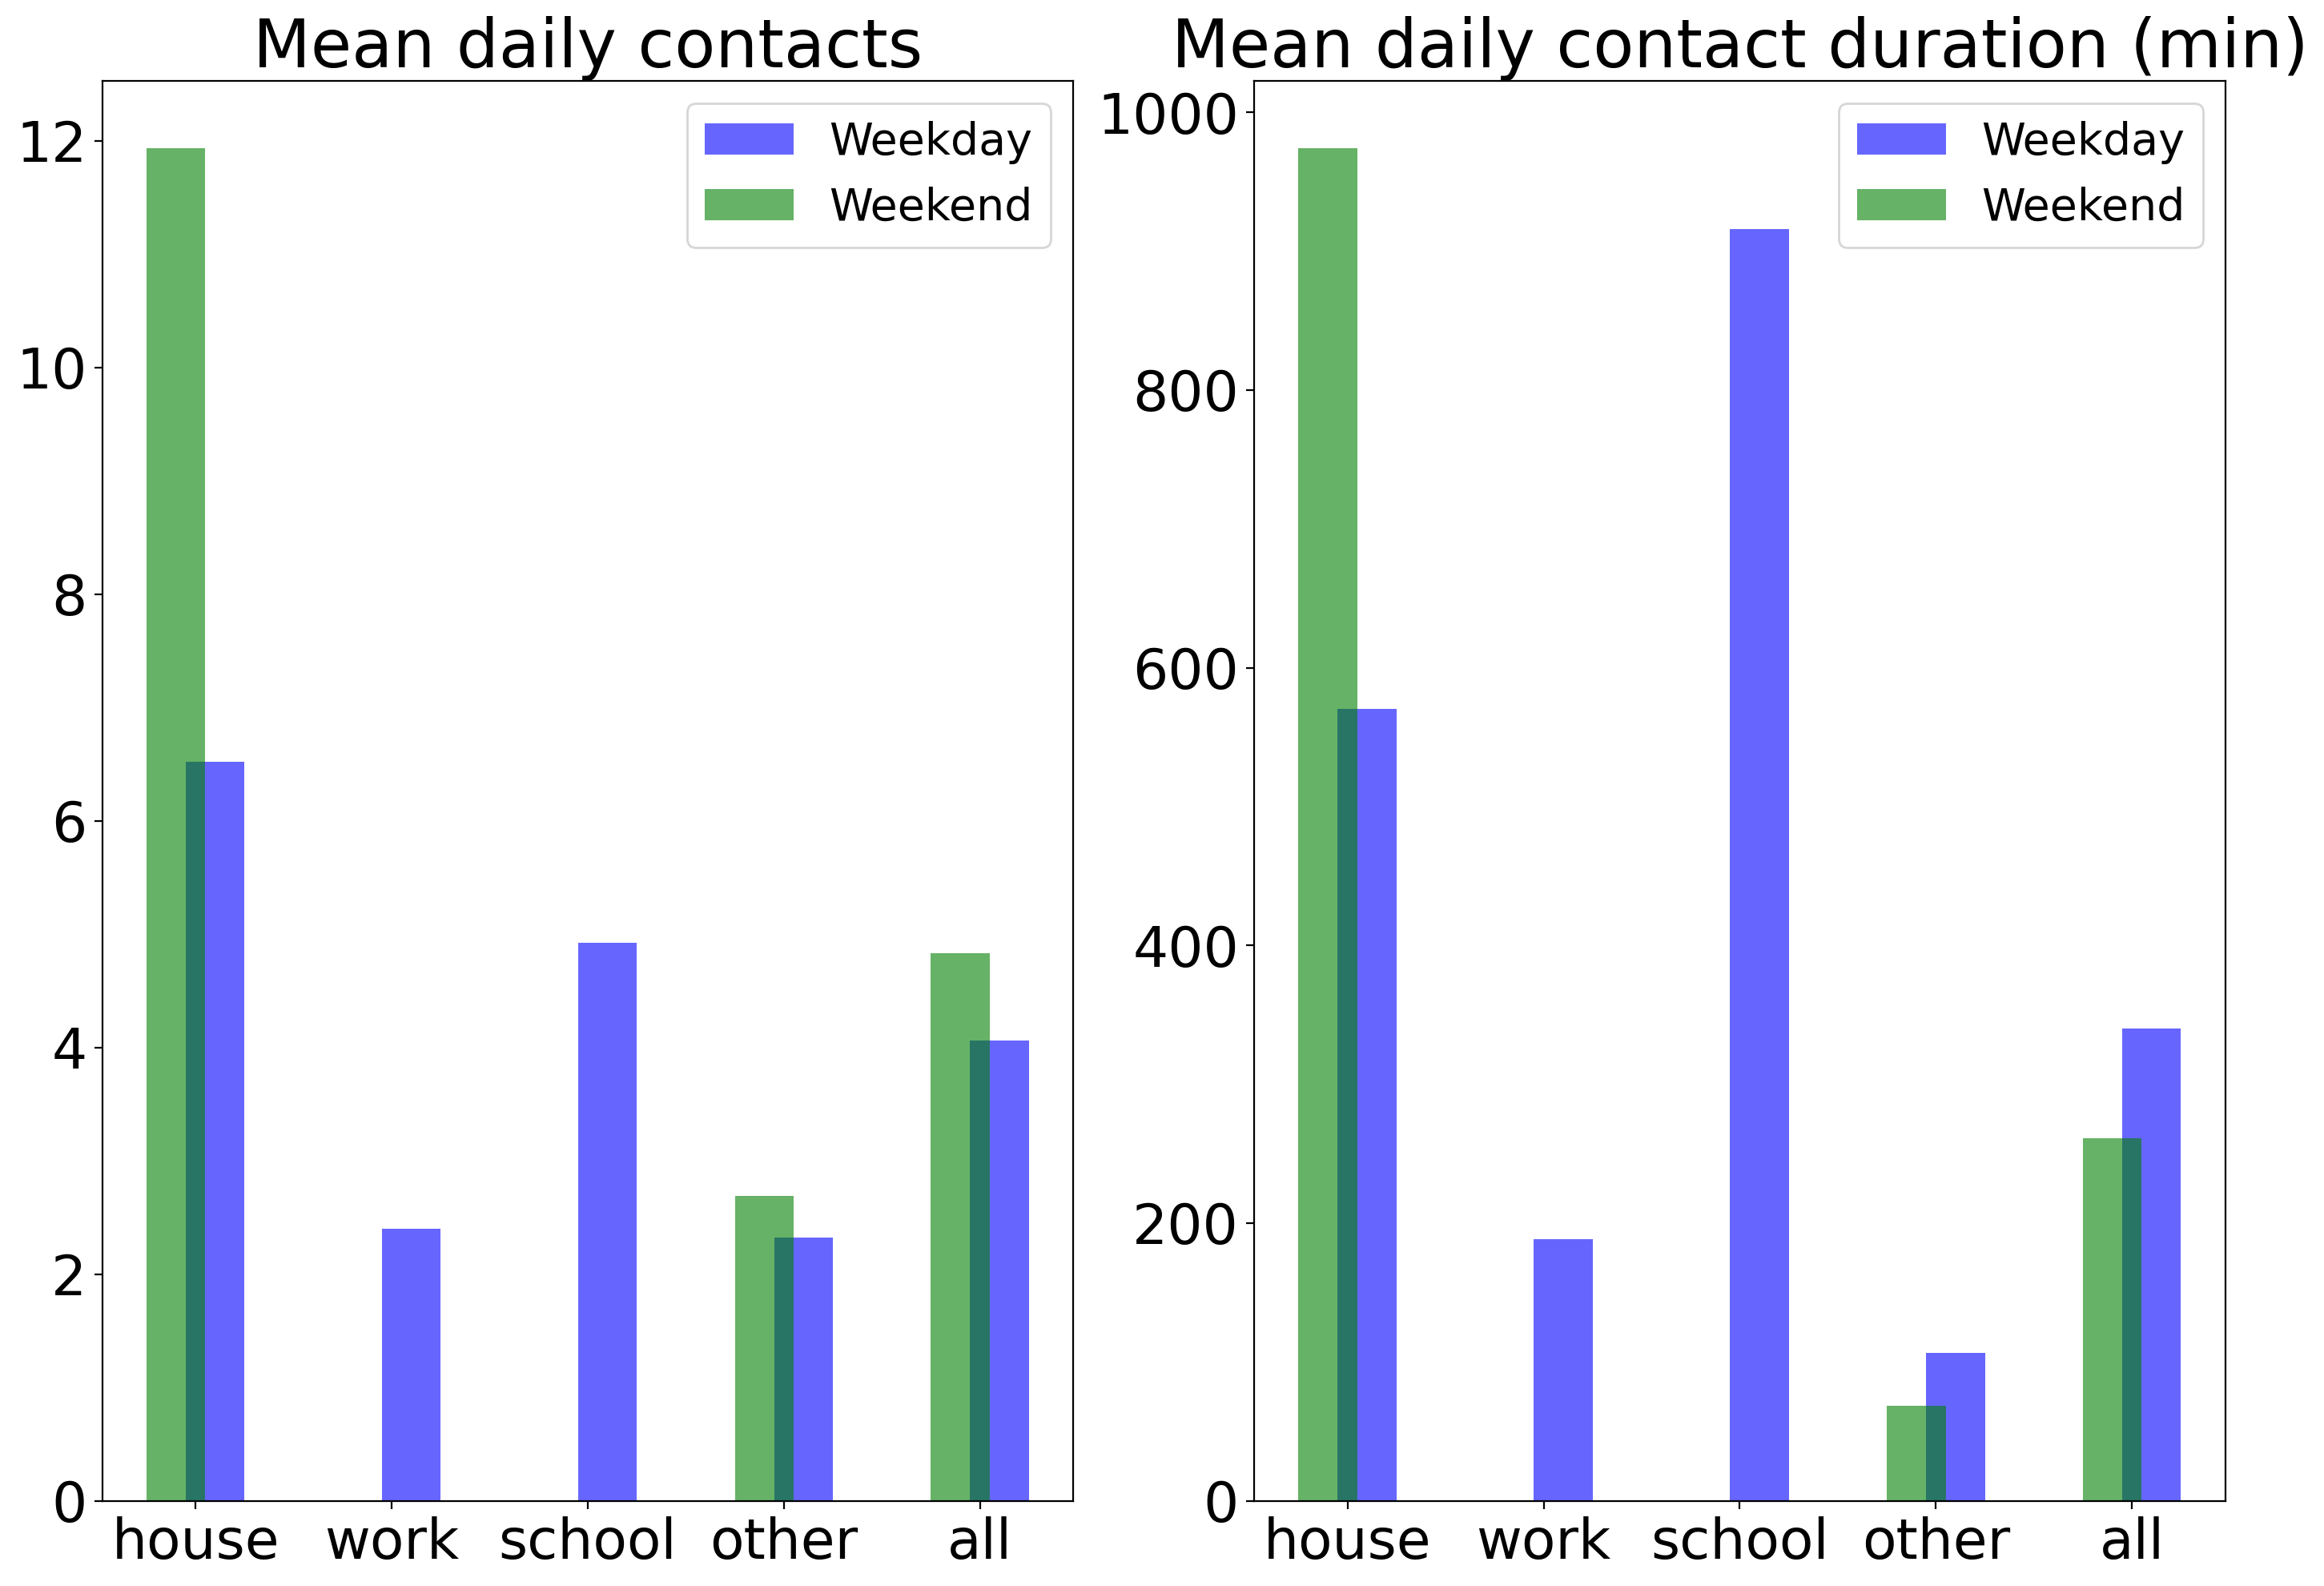

In [57]:
# scalars 
# mean_daily_contacts
# mean_daily_contact_duration
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,10), dpi=200)
LOCATIONS = ['house', 'work', 'school', 'other', 'all']
N_BARS = len(LOCATIONS)
TICKSIZE = 25
TITLESIZE = 30

idx = -1
for metric in ['mean_daily_contacts', 'mean_daily_contact_duration']:
    idx += 1
    contacts = data['contact_patterns'][metric]
    if metric == "mean_daily_contacts":
        TITLE = "Mean daily contacts"
    elif metric == "mean_daily_contact_duration":
        TITLE = "Mean daily contact duration (min)"
        
    
    # contact 
    ax = axs[idx]

    weekday = [contacts['weekday'][x][1] for x in LOCATIONS]
    ax.bar(x=range(1, 2*N_BARS+1, 2), height=weekday, align='edge', width=-0.6, label="Weekday", color="blue", alpha=0.6)

    weekend = [contacts['weekend'][x][1] for x in LOCATIONS]
    ax.bar(x=range(0, 2*N_BARS, 2), height=weekend, align='edge', width=0.6, label="Weekend", color="green", alpha=0.6)

    # xticks and labels
    ax.set_xticks(np.arange(0.5, 2*N_BARS, 2))
    ax.set_xticklabels(LOCATIONS, rotation=0) 
    ax.set_title(TITLE, fontsize=TITLESIZE)
    ax.legend(prop={"size":20}, loc="upper right")

    # tick size
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(TICKSIZE)
        
fig.tight_layout()

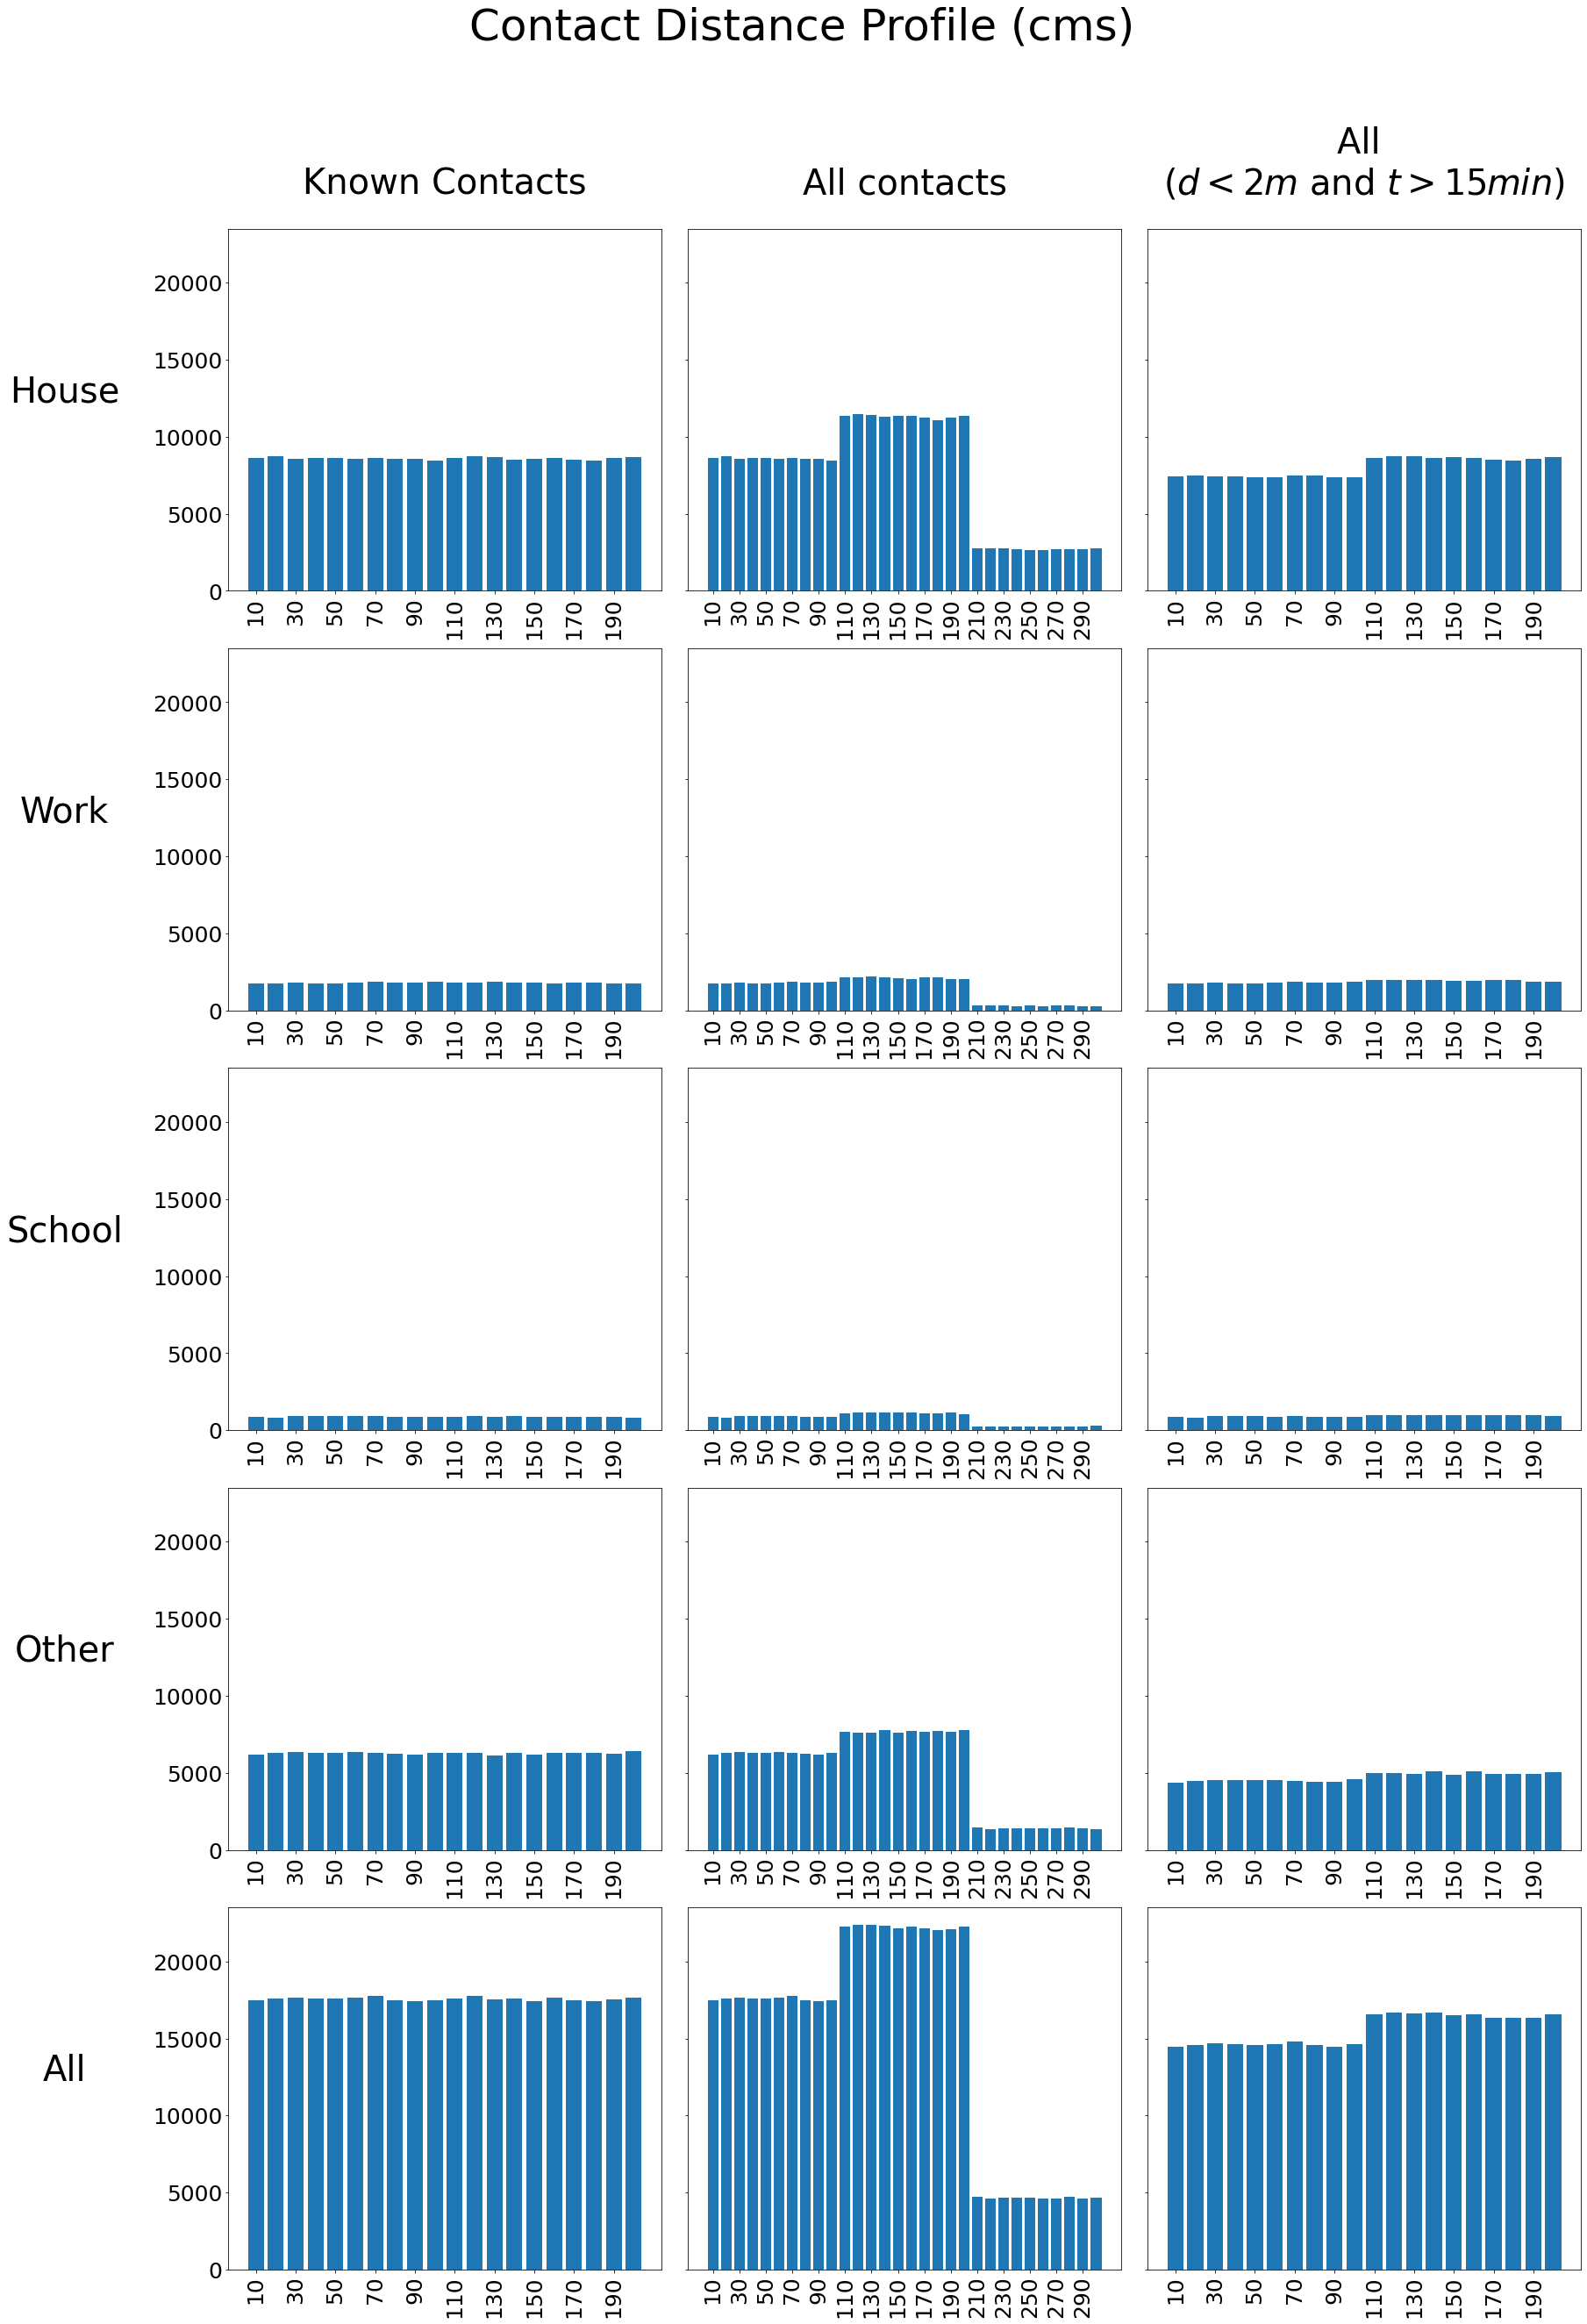

In [58]:
# interaction characteristics
# known, all, within contact condition; location type - [..], distribution

# contact_distance_profile
# contact_duration_profile


metric = "contact_distance_profile"
if metric == "contact_distance_profile":
    TITLE = "Contact Distance Profile (cms)"
else:
    TITLE = "Contact Duration Profile"

TITLESIZE = 40
TITLEPAD = 40
YLABELSIZE = 40
YLABELPAD = 100
TICKSIZE = 25

HEIGHT = 7
WIDTH = 7.5
EXTRA_WIDTH = 3

ncols = 3 # ['known', 'all', 'within_contact_condition']
nrows = len(LOCATION_TYPES_TO_TRACK_MIXING)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(WIDTH*ncols+EXTRA_WIDTH, HEIGHT*nrows), sharex=False, sharey=True)

# set row and column headers 
for col in range(ncols):
    interaction = INTERACTION_TYPE_LABELS[INTERACTION_TYPES[col]]
    axs[0, col].set_title(interaction, pad=TITLEPAD, fontsize=TITLESIZE)

for row in range(nrows):
    location = LOCATION_LABELS[LOCATION_TYPES_TO_TRACK_MIXING[row]]
    axs[row, 0].set_ylabel(location, rotation=0, labelpad=YLABELPAD, fontsize=YLABELSIZE)

for row in range(nrows):
    location = LOCATION_TYPES_TO_TRACK_MIXING[row]
    for col in range(ncols):
        interaction = INTERACTION_TYPES[col]
        ax = axs[row][col]

        # data
        # others
        hist = data['contact_patterns'][metric][interaction][location]
        if len(hist) == 0:
            continue
        hist = np.array(sorted(hist.items(), key=lambda x:x[0]))
        ax.bar(x=range(0, hist.shape[0]), height=hist[:,1], align="center", width=0.8)
        
        # set positioning 
#         ax.set(adjustable='box', aspect=1)

        # xticks and labels
        xlabels = hist[:,0][::2]
        ax.set_xticks(range(0, hist.shape[0], 2))
        ax.set_xticklabels(xlabels, rotation=90)

        # tick size
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(TICKSIZE)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(TICKSIZE)

fig.suptitle(TITLE, fontsize=50, y=1.05)
fig.tight_layout()


In [ ]:
# contact network (small worldness)

In [63]:
filename = "../src/covid19sim/output/sim_v2_people-1000_days-15_init-0.001_uptake--1.0_seed-0_20200714-091858_306000/tracker_data_n_1000_seed_0_20200714-092045.pkl"
data = pickle.load(open(filename, "rb"))

In [68]:
import networkx as nx 
graph = nx.Graph()
all_connections = data['known_connections']
graph.add_edges_from([(human, connection) for human, connections in all_connections.items() for connection in connections])

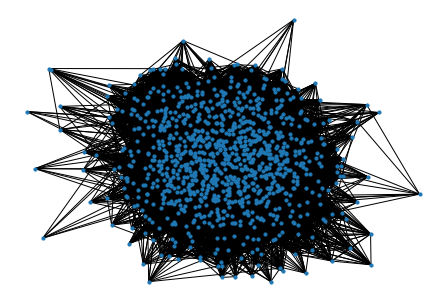

In [71]:
nx.draw(graph, node_size=10)

In [72]:
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 1000\nNumber of edges: 51107\nAverage degree: 102.2140'

In [73]:
nx.algorithms.smallworld.sigma(graph, niter=50)

KeyboardInterrupt: 